In [61]:
# importing libraries:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import json
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

#### Begining the ETL Process :

In [2]:
# establishing the connection with the local database:
conn = sqlite3.connect('my_database.db')

In [3]:
df_funding = pd.read_excel('crowdfunding.xlsx')
df_contacts = pd.read_excel('contacts.xlsx',header=3)
df_funding.head(2)

,cf_id,contact_id,company_name,blurb,goal,pledged,outcome,backers_count,country,currency,launched_at,deadline,staff_pick,spotlight,category & sub-category
0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100,0,failed,0,CA,CAD,1581573600,1614578400,False,False,food/food trucks
1,1621,3765,Odom Inc,Managed bottom-line architecture,1400,14560,successful,158,US,USD,1611554400,1621918800,False,True,music/rock


In [4]:
df_funding.columns

Index(['cf_id', 'contact_id', 'company_name', 'blurb', 'goal', 'pledged',
       'outcome', 'backers_count', 'country', 'currency', 'launched_at',
       'deadline', 'staff_pick', 'spotlight', 'category & sub-category'],
      dtype='object')

In [5]:
df_funding[['category','subcategory']] = df_funding['category & sub-category'].str.split('/',n=1,expand=True)
df_funding.head(2)

,cf_id,contact_id,company_name,blurb,goal,pledged,outcome,backers_count,country,currency,launched_at,deadline,staff_pick,spotlight,category & sub-category,category,subcategory
0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100,0,failed,0,CA,CAD,1581573600,1614578400,False,False,food/food trucks,food,food trucks
1,1621,3765,Odom Inc,Managed bottom-line architecture,1400,14560,successful,158,US,USD,1611554400,1621918800,False,True,music/rock,music,rock


In [6]:
# After visualizing the first two rows following Transformation are required:
# categories and subcategories are to seperated and a seperated data frame is to be created for the sql database.
# few columns have to be renamed:
## checking how many categories and subcategories are present do that we can tag them.
categories = df_funding["category"].unique()
subcategories = df_funding["subcategory"].unique()
print(f'categories: {len(categories)}\nsubcategories: {len(subcategories)}')

categories: 9
subcategories: 24


In [7]:
category_ids = np.arange(1,10)
subcategories = np.arange(1,25)

In [8]:
cat_ids = ['cat' + str(i) for i in category_ids]
subcat_ids = ['subcat'+str(i) for i in subcategories]

In [9]:
df_category = pd.DataFrame({
    'category_id' : cat_ids,
    'category' : categories
})
df_subcategory = pd.DataFrame({
    'subcategory_ids' : subcat_ids,
    'subcategories': subcategories
})

In [10]:
# Now that we have the seperate dataframes,the next step is to save them as csv and in the database.
df_category.to_csv('cleaned_data/category.csv',index = False)
df_category.to_sql('category',conn,if_exists='replace')
df_subcategory.to_csv('cleaned_data/subcategory.csv',index=False)
df_subcategory.to_sql('subcategory',conn,if_exists='replace')

24

In [11]:
df_campaign = df_funding.copy()

In [12]:
# columns that were to be renamed :
df_campaign = df_campaign.rename(columns={'blurb':'description','launched_at':'launch_date','deadline':'end_date'})
df_campaign.head(2)

,cf_id,contact_id,company_name,description,goal,pledged,outcome,backers_count,country,currency,launch_date,end_date,staff_pick,spotlight,category & sub-category,category,subcategory
0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100,0,failed,0,CA,CAD,1581573600,1614578400,False,False,food/food trucks,food,food trucks
1,1621,3765,Odom Inc,Managed bottom-line architecture,1400,14560,successful,158,US,USD,1611554400,1621918800,False,True,music/rock,music,rock


In [13]:
def preprocessing_data(data):
    '''
    This function acts as a pipeline on the dataframe provided.
    Following procedures are executed and findings are reported :
    1 - It looks for nulls and report them if found.
    2 - It looks for any duplicate, and reports them if found.
    3 - If there are any columns with data type as object it reports them to verify if they are categorical in nature or
    do they need to be casted in their appropriate data type.
    4 - It scans for column names and see if there is 'date' mentioned any where and reports those columns,
    in order to make any necessary changes.
    5 - Finally it prints out the findings and returns the dataset.
    '''
#     The following code handles null values
    null_values = data.isnull().sum()

    null_columns = []
    if any(null_values) > 0:
        print('The following columns have null values:')
    else:
        print('No null values were found.')
    for i,x in null_values.items():
        if x > 0:
            print(i)
            null_values.append(i)
#     The following section checks for duplicates and then removes them.
    duplicates_present = data.duplicated().sum()
    if duplicates_present > 0:
        print('The data contains duplicate rows, which will be dropped.')
    else :
        print('No duplicates were found.')
    data = data.drop_duplicates()
#     The following code yields if there are columns with categorical 
#     values and prints them out.
    data_type = data.dtypes
    categorical_columns = []
    for i,x in data_type.items():
        if x == 'object':
            categorical_columns.append(i)
    print(f'Folowing columns have categorical values: {categorical_columns}')
#     This code yields if there is any columns with date in name so we check if the 
#     appropriate format is applied:
    date_columns=list(data.columns[data.columns.str.contains('date',case=False)])
    if len(date_columns) != 0:
        print(f'Confirm the appropriate data types of the following columns:\n{date_columns}')
        
    return data
            

In [14]:
data = preprocessing_data(df_campaign)

No null values were found.
No duplicates were found.
Folowing columns have categorical values: ['company_name', 'description', 'outcome', 'country', 'currency', 'category & sub-category', 'category', 'subcategory']
Confirm the appropriate data types of the following columns:
['launch_date', 'end_date']


### Lets investigate the findings :

In [15]:
data[['launch_date','end_date']][:2]

,launch_date,end_date
0,1581573600,1614578400
1,1611554400,1621918800


In [16]:
# According to the pipeline the categorical columns by name should be categorical and as our finding 
# confirms that launch_date and end_date needs to be formatted.

In [17]:
# Formatting launch_date columns and end_date columns accordingly:
data['launch_date'] = pd.to_datetime(data['launch_date'],unit='s').dt.strftime('%Y-%m-%d')
data['end_date'] = pd.to_datetime(data['end_date'],unit='s').dt.strftime('%Y-%m-%d')

In [18]:
# The next step would be to drop colums that are not required :
data_cleaned = data.drop(columns =['staff_pick', 'spotlight', 'category & sub-category'])

In [19]:
data_cleaned.columns

Index(['cf_id', 'contact_id', 'company_name', 'description', 'goal', 'pledged',
       'outcome', 'backers_count', 'country', 'currency', 'launch_date',
       'end_date', 'category', 'subcategory'],
      dtype='object')

In [20]:
# saving the campaign data as csv and in database:
data_cleaned.to_sql('cleaned_campaignData',conn,if_exists='replace')
data_cleaned.to_csv('cleaned_data/cleaned_campaignData.csv',index=False)

### Exploring the contacts data :

In [21]:
df_contacts.head(2)

,contact_info
0,"{""contact_id"": 4661, ""name"": ""Cecilia Velasco""..."
1,"{""contact_id"": 3765, ""name"": ""Mariana Ellis"", ..."


In [22]:
# transfroming the data:
values = []
for i in df_contacts['contact_info']:
    x = json.loads(i)
    values.append(x.values())
df_contact = pd.DataFrame(values,columns=['contact_id', 'name', 'email'])

In [23]:
df_contact.head(2)

,contact_id,name,email
0,4661,Cecilia Velasco,cecilia.velasco@rodrigues.fr
1,3765,Mariana Ellis,mariana.ellis@rossi.org


In [24]:
# The next step is to split the name data into first name and last name:
df_contact[['first_name','last_name']] = df_contact.name.str.split(' ',n=1,expand=True)

In [25]:
df_contact.drop(columns='name',inplace=True)

In [26]:
df_contact.head()

,contact_id,email,first_name,last_name
0,4661,cecilia.velasco@rodrigues.fr,Cecilia,Velasco
1,3765,mariana.ellis@rossi.org,Mariana,Ellis
2,4187,sofie.woods@riviere.com,Sofie,Woods
3,4941,jeanette.iannotti@yahoo.com,Jeanette,Iannotti
4,2199,samuel.sorgatz@gmail.com,Samuel,Sorgatz


In [27]:
# Reorganizing the columns:
cleaned_contacts = df_contact[['contact_id','first_name', 'last_name', 'email']]
cleaned_contacts.head(2)                              

,contact_id,first_name,last_name,email
0,4661,Cecilia,Velasco,cecilia.velasco@rodrigues.fr
1,3765,Mariana,Ellis,mariana.ellis@rossi.org


In [28]:
# Loading the transformed data :
cleaned_contacts.to_csv('cleaned_data/contacts_cleaned.csv',encoding='utf8',index=False)
cleaned_contacts.to_sql('contacts_cleaned',conn,if_exists='replace')

1000

In [29]:
# closing the database connection.
conn.close()

### Now that we are done with ETL process, the next step would be to initiate EDA :

In [30]:
# establishing the connection again to retrieve data 
conn = sqlite3.connect('my_database.db')

In [31]:
df = pd.read_sql_query('SELECT * FROM cleaned_campaignData',conn)

In [32]:
# lets visualize the data:
df.head(2)

,index,cf_id,contact_id,company_name,description,goal,pledged,outcome,backers_count,country,currency,launch_date,end_date,category,subcategory
0,0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100,0,failed,0,CA,CAD,2020-02-13,2021-03-01,food,food trucks
1,1,1621,3765,Odom Inc,Managed bottom-line architecture,1400,14560,successful,158,US,USD,2021-01-25,2021-05-25,music,rock


In [33]:
# Going through the columns to select the unwanted columns and drop them:
df.columns

Index(['index', 'cf_id', 'contact_id', 'company_name', 'description', 'goal',
       'pledged', 'outcome', 'backers_count', 'country', 'currency',
       'launch_date', 'end_date', 'category', 'subcategory'],
      dtype='object')

In [34]:
# dropping the columns:
drop_columns = ['description','cf_id','index','currency','contact_id']

In [35]:
df = df.drop(columns=drop_columns)

In [36]:
df.head(2)

,company_name,goal,pledged,outcome,backers_count,country,launch_date,end_date,category,subcategory
0,"Baldwin, Riley and Jackson",100,0,failed,0,CA,2020-02-13,2021-03-01,food,food trucks
1,Odom Inc,1400,14560,successful,158,US,2021-01-25,2021-05-25,music,rock


In [37]:
# maximum pledged by a single company:
for i,x in df.iterrows():
    if x['pledged'] == df['pledged'].max():
        print(x)

company_name      Jackson Inc
goal                   196900
pledged                199110
outcome            successful
backers_count            2053
country                    US
launch_date        2020-12-07
end_date           2021-08-21
category         film & video
subcategory       documentary
Name: 208, dtype: object


In [38]:
# Lets find out the categories and count of pledges each of them got:
pledged_category = df.groupby(by='category').sum(numeric_only=True)

pledged_category.head()

,goal,pledged,backers_count
category,,,
film & video,8744700,7510076,121875
food,1921300,1735179,28846
games,2858000,2015817,37662
journalism,25700,36176,1194
music,7026300,7480097,129002


<Axes: xlabel='category'>

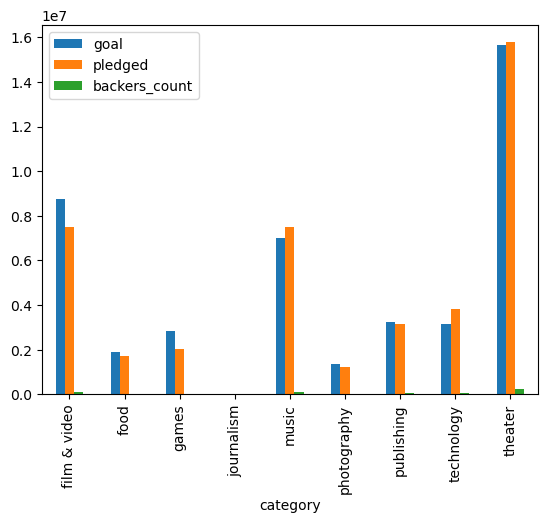

In [39]:
# plotting the above derived information :
pledged_category.plot(kind = 'bar')

In [40]:
# A little feature engineering on the side to study the effect of campaign duration on pledges:
df.launch_date = pd.to_datetime(df.launch_date)

df.end_date = pd.to_datetime(df.end_date)

In [41]:
# Lets see if duration between launch date and end date have any impact ;
df['duration'] = (df.end_date -df.launch_date).astype(str)

df.head(2)

,company_name,goal,pledged,outcome,backers_count,country,launch_date,end_date,category,subcategory,duration
0,"Baldwin, Riley and Jackson",100,0,failed,0,CA,2020-02-13,2021-03-01,food,food trucks,382 days
1,Odom Inc,1400,14560,successful,158,US,2021-01-25,2021-05-25,music,rock,120 days


In [42]:
df.duration = df.duration.str.replace(' days','')
df.duration = df.duration.astype(int)

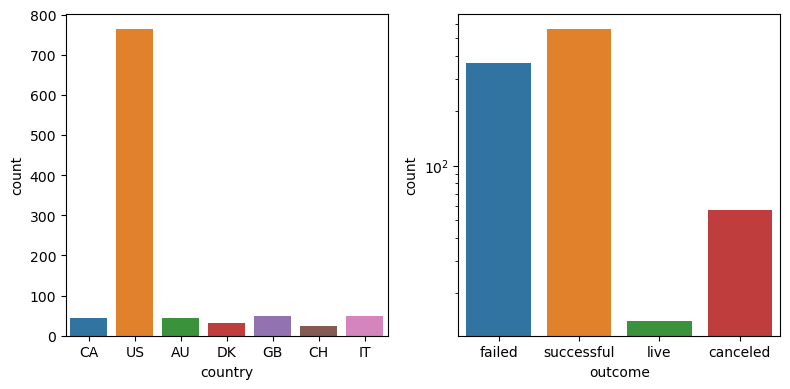

In [51]:
# Plotting the countries and the number of pledges to figure out which country had the greatest number:
col_plot = ['country','outcome']

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
axs = axs.flatten()
for i,x in enumerate(col_plot):
    sns.countplot(data=df,x=x,ax=axs[i])
plt.tight_layout()
plt.yscale('log')
plt.show()

In [52]:
# Feature Enginnering number two cateorizing our duration data in order to study the effecty :
bins = list(np.arange(0,380,75))
labels = ['short','medium','long','very_long','extended']
df['bin_duration'] = pd.cut(df.duration,bins=bins,labels=labels)
duration_pleadges = df.groupby(by='bin_duration').count()
duration_pleadges

,company_name,goal,pledged,outcome,backers_count,country,launch_date,end_date,category,subcategory,duration
bin_duration,,,,,,,,,,,
short,192,192,192,192,192,192,192,192,192,192,192
medium,221,221,221,221,221,221,221,221,221,221,221
long,182,182,182,182,182,182,182,182,182,182,182
very_long,186,186,186,186,186,186,186,186,186,186,186
extended,180,180,180,180,180,180,180,180,180,180,180


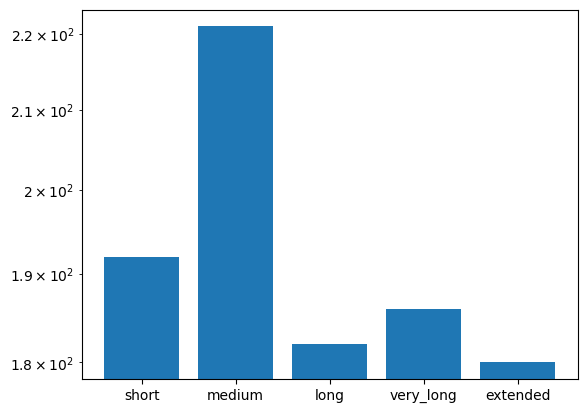

In [54]:
# Visualizing the engineered data:
plt.bar(x=duration_pleadges.index,height='pledged',data=duration_pleadges)
plt.yscale('log')
plt.show()

<Axes: xlabel='outcome'>

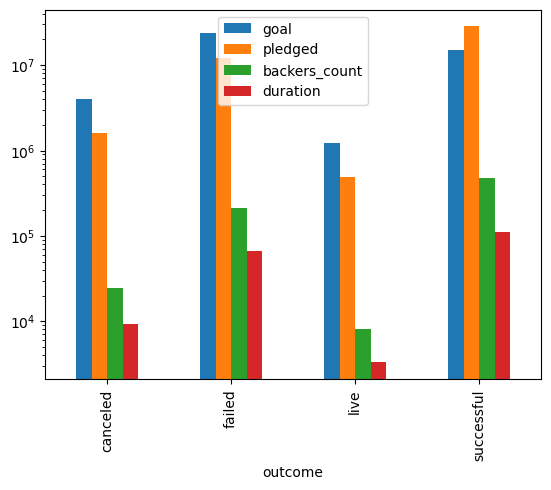

In [56]:
# Studying outcomes of the pledges against the total goal, pledged, backers count and duration
outcomes = df.groupby(by='outcome').sum(numeric_only=True)

outcomes.plot(kind='bar',logy=True)

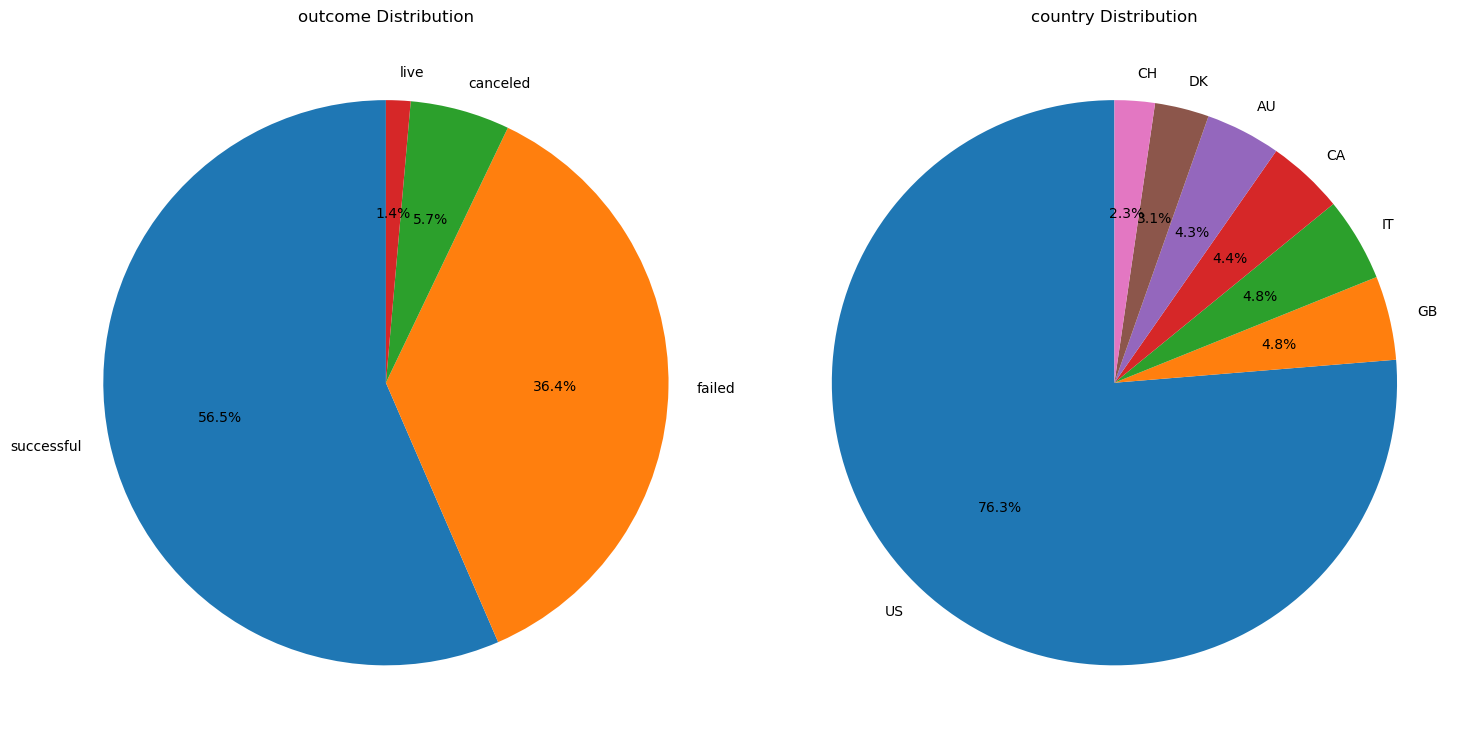

In [58]:
# Visualizing the outcome distribution  and country distribution: 
category = ['outcome','country']

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,15))
axs = axs.flatten()
for i, x in enumerate(category):
    if i < len(axs):
        counts = df[x].value_counts()
        axs[i].pie(counts,labels=counts.index,autopct='%1.1f%%',startangle=90)
        axs[i].set_title(f'{x} Distribution')
fig.tight_layout()
plt.show()

### Now its time for Statistical Analysis:

<Axes: >

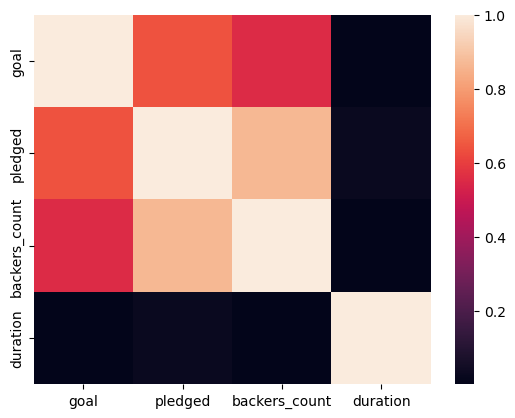

In [63]:
# Lets see if there are any meaningful correlations:
sns.heatmap(df.corr())

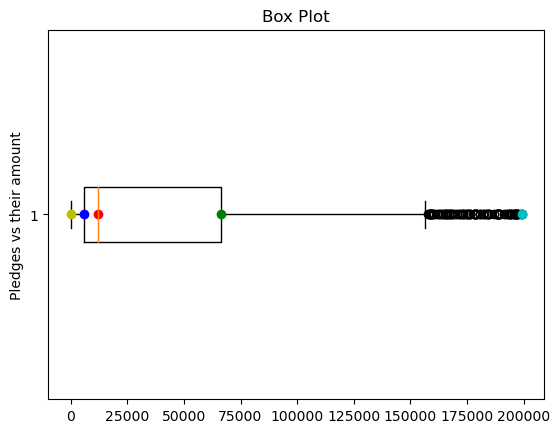

In [84]:
# Lets Study the spread of our pledges:
plt.boxplot(df.pledged,vert=False)
plt.plot(df.pledged.median(),1,'ro',label='Median')
plt.plot(df.pledged.quantile(0.25),1,'bo',label='q1')
plt.plot(df.pledged.quantile(0.75),1,'go',label='q3')
plt.plot(df.pledged.min(),1,'yo',label='Min')
plt.plot(df.pledged.max(),1,'co',label='Max')
plt.title('Box Plot')
plt.ylabel('Pledges vs their amount')
plt.show()

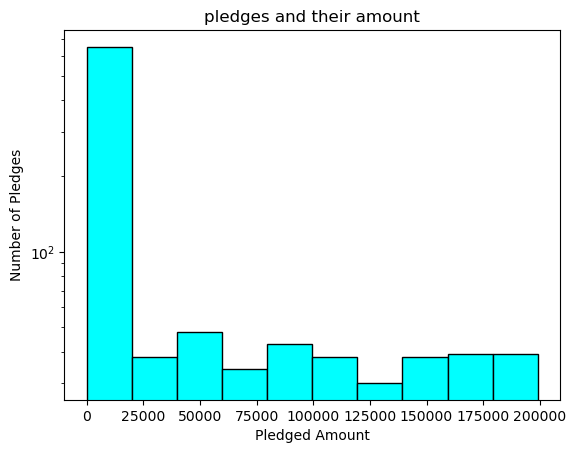

In [86]:
plt.hist(df.pledged, bins=10, color='cyan', edgecolor='black')

# Customize the plot
plt.title('pledges and their amount')
plt.xlabel('Pledged Amount')
plt.ylabel('Number of Pledges')
plt.yscale('log')

# Display the plot
plt.show()

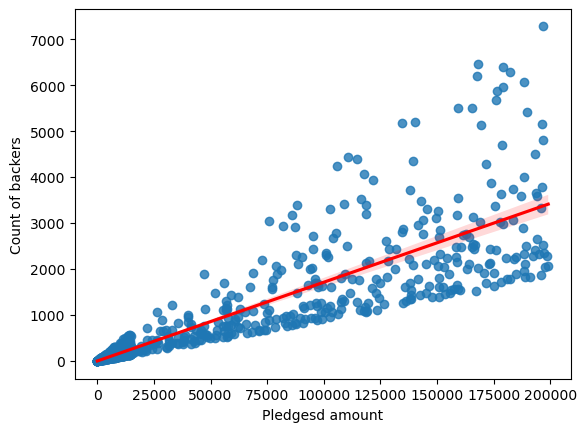

In [85]:
# To see if there is any correlation with the number of backers and amount pledged:
sns.regplot(x = df.pledged,y = df.backers_count,line_kws={'color':'red'})
plt.xlabel('Pledgesd amount')
plt.ylabel('Count of backers')
plt.show()

In [87]:
# These findings are now to be presented to the stake holders.